In [1]:
import pandas as pd
import numpy as np

from pathlib import Path

In [2]:
data_path = Path.cwd().parent.joinpath("train_data_fix_concat.csv")

In [3]:
data = pd.read_csv(data_path.__str__())
data = data.drop_duplicates()
data = data[data['oil_property_param_value'].notna()]

### Тип масла - Масло - свойство - компоненты - свойства компонентов

In [4]:
# Все возможные масла
total_oil_ids = data["blend_id"].drop_duplicates().to_list()
print(f"Total oil ids -- {len(total_oil_ids)}")

# Все используемые компоненты
total_components = list(set(data["component_name"].to_list()))
print(f"Total chemical components -- {len(total_components)}")

# Все возможные свойства компонентов
total_component_properties = list(set(data["component_property_param_title"]))
print(f"Total chemical components properties -- {len(total_component_properties)}")

# Все возможные расширения для компонентов
total_component_classes = list(set(data["component_class"]))
print(f"Total chemical components classes -- {len(total_component_classes)}")



print(f"X vector length -- {len(total_components) * len(total_component_properties)} + N of oil addons")

Total oil ids -- 348
Total chemical components -- 112
Total chemical components properties -- 63
Total chemical components classes -- 14
X vector length -- 7056 + N of oil addons


In [5]:
# Фиксируем только свойство по ТЗ
workdata = data
workdata_oil_ids = list(set(workdata["blend_id"].to_list()))

### Создаем шаблон вектора X

In [8]:
vector_template = np.zeros(len(total_components) * len(total_component_properties))

def convertDataToVector(components, components_propeties_names, components_propetries_values):
    result_vector = np.zeros(len(total_components) * len(total_component_properties))
    result_vector = np.array([np.float64(-1.0) for x in result_vector])
    
    for component_index, component_name in enumerate(components):
        
        # Индекс в векторе конкретного компонента
        component_vector_index = total_components.index(component_name)
        
        for component_property_index, component_propetry in enumerate(components_propeties_names[component_index]):

            # Индекс в векторе конкретного свойства компонента
            property_vector_index = total_component_properties.index(component_propetry)

            inserting_index = int((component_vector_index *  len(total_component_properties)) + property_vector_index)
            result_vector[inserting_index] = components_propetries_values[component_index][component_property_index]
            
    return result_vector

### 1) Кодируем масло в вектор компонент

In [9]:
Y_data = []
X_data = []

In [10]:
current_id = workdata_oil_ids[1]

for index in range(len(workdata_oil_ids)):
    current_id = workdata_oil_ids[index]
    current_oil_data = workdata.loc[workdata["blend_id"] == current_id]
    
    components_in_oil = list(set(current_oil_data["component_name"].to_list()))
    
    components_propetries_to_function = []
    components_values_to_function = []
    
    for component in components_in_oil:
        # Извлекаю данные
        current_component_oil_data = current_oil_data.loc[current_oil_data["component_name"] == component]
        components_addons_class = list(set(current_component_oil_data["component_class"].to_list()))
        components_addons_polymer = list(set(current_component_oil_data["polymer"].to_list()))
        components_properties = current_component_oil_data["component_property_param_title"].to_list()
    
        # Подготавливаю для вектора
        current_component_properties = []
        current_component_values = []
    
        # Забираю значения по свойствам
        for component_property in components_properties:
            current_property_component_oil_data = current_component_oil_data.loc[current_component_oil_data["component_property_param_title"] == component_property]
            value = current_property_component_oil_data["component_property_param_value"].fillna(0.0).values[0]
            
            current_component_properties.append(component_property)
            current_component_values.append(value)
    
        # Добавляю по свойствам для функции векторизации
        components_values_to_function.append(current_component_values)
        components_propetries_to_function.append(current_component_properties)

    current_result_vector = convertDataToVector(components_in_oil, components_propetries_to_function, components_values_to_function)

    X_data.append(current_result_vector)
    Y_data.append(list(set(current_oil_data["oil_property_param_value"].to_list()))[0])

### 2) Формируем набор данных для обучения

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.1)

In [17]:
len(x_test)

35

### 3) Обучаем разные модели, смотрим по МАЕ какая лучше

In [18]:
from sklearn.linear_model import PassiveAggressiveRegressor

kostyan = PassiveAggressiveRegressor(max_iter=100, random_state=0)
kostyan.fit(x_train, y_train)

PassiveAggressiveRegressor(max_iter=100, random_state=0)

In [23]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron(random_state=0)
perceptron.fit(x_train, y_train)

ValueError: Unknown label type: (array([-6.4000e+01, -6.3000e+01, -6.2000e+01, -5.7000e+01, -5.5000e+01,
       -5.3000e+01, -5.2000e+01, -5.1000e+01, -4.8000e+01, -4.7000e+01,
       -4.5000e+01, -4.4000e+01, -4.3000e+01, -4.1000e+01, -4.0000e+01,
       -3.9000e+01,  0.0000e+00,  1.5000e-02,  1.6000e-02,  3.1000e-02,
        3.4000e-02,  4.6000e-02,  4.7000e-02,  4.8000e-02,  4.9000e-02,
        5.0000e-02,  6.4000e-02,  7.3000e-02,  7.4000e-02,  7.5000e-02,
        1.1000e-01,  1.6200e-01,  1.6400e-01,  1.6500e-01,  1.6600e-01,
        1.6700e-01,  1.6800e-01,  1.7700e-01,  1.8500e-01,  2.0000e-01,
        2.1000e-01,  3.3400e-01,  3.3700e-01,  3.5700e-01,  3.5900e-01,
        3.6700e-01,  3.7000e-01,  3.7800e-01,  3.9100e-01,  4.4000e-01,
        4.6000e-01,  4.7200e-01,  4.7800e-01,  6.3000e-01,  6.8000e-01,
        7.0000e-01,  7.2000e-01,  7.3100e-01,  8.0400e-01,  8.3000e-01,
        8.5000e-01,  8.8000e-01,  8.9200e-01,  9.4300e-01,  1.0000e+00,
        1.2300e+00,  1.7000e+00,  1.8500e+00,  1.9300e+00,  2.1700e+00,
        2.2400e+00,  2.2600e+00,  2.2800e+00,  2.6500e+00,  2.8500e+00,
        3.0000e+00,  3.1000e+00,  3.1100e+00,  3.1200e+00,  3.2400e+00,
        3.4200e+00,  3.5000e+00,  3.5100e+00,  3.6000e+00,  3.6500e+00,
        3.7000e+00,  3.7500e+00,  3.7800e+00,  3.8500e+00,  3.8600e+00,
        3.8700e+00,  3.9700e+00,  4.0000e+00,  4.0400e+00,  4.3000e+00,
        4.4300e+00,  4.4400e+00,  4.4800e+00,  4.5000e+00,  4.5200e+00,
        4.7500e+00,  4.7600e+00,  4.9700e+00,  4.9800e+00,  5.0000e+00,
        5.1200e+00,  5.3700e+00,  5.5000e+00,  6.0000e+00,  7.0000e+00,
        8.0200e+00,  8.2000e+00,  8.2780e+00,  8.3600e+00,  8.4420e+00,
        8.5000e+00,  8.9900e+00,  9.3300e+00,  9.4200e+00,  9.4600e+00,
        9.7400e+00,  9.9000e+00,  1.0170e+01,  1.0620e+01,  1.1070e+01,
        1.6020e+01,  1.6050e+01,  1.6140e+01,  1.6180e+01,  1.6230e+01,
        1.6240e+01,  1.6280e+01,  1.6340e+01,  1.6360e+01,  1.6380e+01,
        1.6400e+01,  1.6430e+01,  1.6520e+01,  1.6550e+01,  1.7390e+01,
        1.7960e+01,  2.5320e+01,  2.6010e+01,  2.6120e+01,  3.2070e+01,
        3.2980e+01,  3.4840e+01,  9.6590e+01,  1.3000e+02,  1.6600e+02,
        1.7000e+02,  1.9200e+02,  1.9750e+02,  4.8000e+02,  8.6400e+02,
        8.6480e+02,  1.4720e+03,  1.5060e+03,  1.7490e+03,  1.9360e+03,
        2.5960e+03,  2.7220e+03,  3.3600e+03,  4.0020e+03,  4.6400e+03,
        4.9630e+03,  6.0590e+03,  6.3070e+03,  6.3700e+03,  8.6740e+03,
        1.0297e+04,  1.0562e+04,  1.0650e+04,  1.1040e+04,  1.3010e+04,
        1.5040e+04,  1.6640e+04,  1.6800e+04,  1.6815e+04,  1.7275e+04,
        1.8195e+04,  1.9200e+04,  1.9240e+04,  2.0260e+04,  2.5650e+04,
        3.4400e+04,  3.8340e+04,  4.0515e+04,  5.2600e+04,  7.4975e+04,
        8.0575e+04,  8.2400e+04,  8.4000e+04,  8.5875e+04,  8.8200e+04,
        9.0530e+04,  9.1460e+04,  9.7300e+04,  9.8800e+04,  1.0028e+05,
        1.0770e+05,  1.0775e+05,  1.0820e+05,  1.0900e+05,  1.0980e+05,
        1.1700e+05,  1.1760e+05,  1.1790e+05,  1.1920e+05,  1.2360e+05,
        1.2705e+05,  1.2735e+05,  1.2920e+05,  1.3100e+05,  1.3130e+05,
        1.3190e+05,  1.3410e+05,  1.3440e+05,  1.3505e+05,  1.3580e+05,
        1.3650e+05,  1.3810e+05,  1.3840e+05,  1.4160e+05,  1.4380e+05,
        1.4520e+05,  1.4950e+05,  1.5100e+05,  1.5400e+05,  1.6005e+05,
        1.6620e+05,  1.7985e+05,  2.0220e+05,  4.6460e+05]),)

In [24]:
from sklearn.linear_model import HuberRegressor

huber = HuberRegressor()
huber.fit(x_train, y_train)

C:\Users\Undefined\Documents\GitHub\Neftecode-2-Shisha-Revenge\venv\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


HuberRegressor()

In [25]:
from sklearn.linear_model import TheilSenRegressor

theilsen = TheilSenRegressor(random_state=0)
theilsen.fit(x_train, y_train)

TheilSenRegressor(random_state=0)

In [26]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(max_iter=1000, tol=1e-3)
sgd.fit(x_train, y_train)

SGDRegressor()

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting = GradientBoostingRegressor(random_state=0)
gradient_boosting.fit(x_train, y_train)

GradientBoostingRegressor(random_state=0)

In [28]:
from sklearn.kernel_ridge import KernelRidge

kernel_ridge = KernelRidge(alpha=1.0)
kernel_ridge.fit(x_train, y_train)

KernelRidge(alpha=1.0)

In [29]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(x_train, y_train)

SVR()

In [30]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(x_train, y_train)

knn_neighbors_10 = KNeighborsRegressor(n_neighbors=10)
knn_neighbors_10.fit(x_train, y_train)

knn_neighbors_2 = KNeighborsRegressor(n_neighbors=2)
knn_neighbors_2.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=2)

In [31]:
from sklearn.gaussian_process import GaussianProcessRegressor

gpr = GaussianProcessRegressor()
gpr.fit(x_train, y_train)

GaussianProcessRegressor()

In [32]:
from sklearn import tree

DT = tree.DecisionTreeRegressor()
DT.fit(x_train, y_train)

DecisionTreeRegressor()

In [33]:
from sklearn.ensemble import RandomForestRegressor

rf_200 = RandomForestRegressor(n_estimators=200)
rf_200.fit(x_train, y_train)

rf_200_md_10 = RandomForestRegressor(n_estimators=200, max_depth=10)
rf_200_md_10.fit(x_train, y_train)

rf_200_md_50 = RandomForestRegressor(n_estimators=200, max_depth=50)
rf_200_md_50.fit(x_train, y_train)

rf_2000_md_500 = RandomForestRegressor(n_estimators=2000, max_depth=500)
rf_2000_md_500.fit(x_train, y_train)

RandomForestRegressor(max_depth=500, n_estimators=2000)

In [34]:
clfs = [kostyan, huber, theilsen, sgd, gradient_boosting, kernel_ridge, svr, knn, knn_neighbors_10, knn_neighbors_2, gpr, DT, rf_200, rf_200_md_10, rf_200_md_50, rf_2000_md_500]

In [35]:
names = ["kostyan", "huber", "theilsen", "sgd", "gradient_boosting", "kernel_ridge", "svr", "knn", "knn_neighbors_10", "knn_neighbors_2", "gpr", "DT", "rf_200", "rf_200_md_10", "rf_200_md_50", "rf_2000_md_500"]

In [36]:
from sklearn.metrics import mean_absolute_error

mae_values = []

for index, clf in enumerate(clfs):
    value = mean_absolute_error(y_test, clf.predict(x_test))
    mae_values.append(value)

### 4) Сравнение алгоритмов

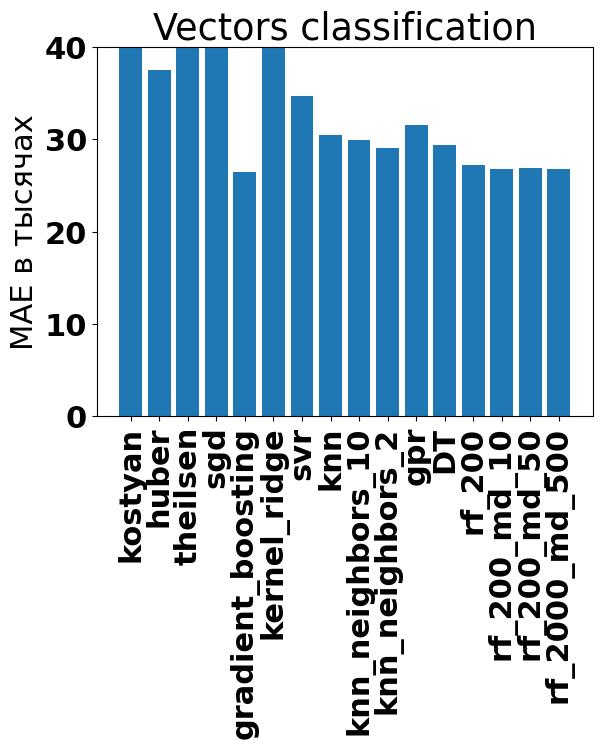

In [37]:
import matplotlib.pyplot as plt
import matplotlib
font = {'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

fig, ax = plt.subplots()
bar_container = ax.bar(names, [x / 1000 for x in mae_values])
ax.set(ylabel='MAE в тысячах', title='Vectors classification', ylim=(0, 40))
plt.rcParams['figure.figsize'] = [20, 20]
plt.xticks(rotation = 90)

fig.savefig("result.png")

### 5) Предсказываем на сабмит

In [332]:
path_to_test_data = Path().cwd().parent.joinpath("test_set_public.csv")

test_df = pd.read_csv(path_to_test_data.__str__())
test_df

,oil_type,blend_id,oil_property_param_title,oil_property_param_value,component_name,component_type_title,component_property_param_title,component_property_param_value
0,c25411c1-0bec-41f3-8eee-81daaed2b890,d272c9a6-3332-11ed-9685-005056921581,7c8a81df-b7e7-4507-aab1-79a61fce7887,4.94,b26322a8-b4fa-41cc-a755-757b41d22919,6063ef2b-3eb8-4bf9-a473-0e3d3042fde7,5cf8e492-dfea-4ecb-8799-a97989c46256,0.0000
1,c25411c1-0bec-41f3-8eee-81daaed2b890,d272c9a6-3332-11ed-9685-005056921581,7c8a81df-b7e7-4507-aab1-79a61fce7887,4.94,b26322a8-b4fa-41cc-a755-757b41d22919,6063ef2b-3eb8-4bf9-a473-0e3d3042fde7,9e2de643-ddca-487e-b9e7-69b25d8662bf,0.0000
2,c25411c1-0bec-41f3-8eee-81daaed2b890,d272c9a6-3332-11ed-9685-005056921581,7c8a81df-b7e7-4507-aab1-79a61fce7887,4.94,b26322a8-b4fa-41cc-a755-757b41d22919,6063ef2b-3eb8-4bf9-a473-0e3d3042fde7,f6cc205c-a44d-40e5-9462-2eab4a673e2a,0.0001
3,c25411c1-0bec-41f3-8eee-81daaed2b890,d272c9a6-3332-11ed-9685-005056921581,7c8a81df-b7e7-4507-aab1-79a61fce7887,4.94,b26322a8-b4fa-41cc-a755-757b41d22919,6063ef2b-3eb8-4bf9-a473-0e3d3042fde7,d6eff30f-788e-48a2-b2bd-cbba188f4e63,0.0006
4,c25411c1-0bec-41f3-8eee-81daaed2b890,d272c9a6-3332-11ed-9685-005056921581,7c8a81df-b7e7-4507-aab1-79a61fce7887,4.94,b26322a8-b4fa-41cc-a755-757b41d22919,6063ef2b-3eb8-4bf9-a473-0e3d3042fde7,049e5cb9-9c20-438c-9ef2-96870712a0be,0.0001
...,...,...,...,...,...,...,...,...
110118,c25411c1-0bec-41f3-8eee-81daaed2b890,97249b7a-9590-11ed-84b7-005056921581,9fa62975-847a-469e-bd3e-e0e133141ab0,1800.00,abf252e5-fe01-4700-847e-fb782e22b50c,fa496c3a-927c-4aee-987a-c84b41ceec11,908bf166-393a-4e90-93d8-5d7b9944d637,0.0000
110119,c25411c1-0bec-41f3-8eee-81daaed2b890,97249b7a-9590-11ed-84b7-005056921581,9fa62975-847a-469e-bd3e-e0e133141ab0,1800.00,abf252e5-fe01-4700-847e-fb782e22b50c,fa496c3a-927c-4aee-987a-c84b41ceec11,d12a35d5-14a3-4828-9c59-bff8e912034d,40.0000
110120,c25411c1-0bec-41f3-8eee-81daaed2b890,97249b7a-9590-11ed-84b7-005056921581,9fa62975-847a-469e-bd3e-e0e133141ab0,1800.00,abf252e5-fe01-4700-847e-fb782e22b50c,fa496c3a-927c-4aee-987a-c84b41ceec11,08db8d40-6b81-44ab-ab91-4b482ebc4187,40.0000
110121,c25411c1-0bec-41f3-8eee-81daaed2b890,97249b7a-9590-11ed-84b7-005056921581,9fa62975-847a-469e-bd3e-e0e133141ab0,1800.00,abf252e5-fe01-4700-847e-fb782e22b50c,fa496c3a-927c-4aee-987a-c84b41ceec11,e3983d82-8773-4e46-8f88-147098d7b87a,15.6000


In [206]:
X_test_vector = []
Ids = []

In [207]:
workdata = test_df.drop_duplicates()
workdata_oil_ids = workdata["blend_id"].drop_duplicates().to_list()
workdata_oil_ids

['d272c9a6-3332-11ed-9685-005056921581',
 'dea007ac-a065-11ed-9f24-005056921581',
 '14efbc8a-9090-11ec-83a1-005056921581',
 'e48772c8-4e07-11ed-9a6d-005056921581',
 '72b7aafa-d791-11ed-8145-005056921581',
 'cf7e06d0-bc99-11ec-9ebf-005056921581',
 'c4af79fc-5a8f-11ed-96db-005056921581',
 '53692f3c-8841-11ee-9dd6-005056921581',
 'bece165e-53fd-11ec-92cf-005056921581',
 'b617ecdc-c4a6-11ec-9ebf-005056921581',
 '4d436672-7ae6-11ed-9727-005056921581',
 '39ec78c0-637a-11ee-92b6-005056921581',
 '03ac1c22-6af9-11ed-8d22-005056921581',
 'ed0f4c7e-9590-11ed-84b7-005056921581',
 'b5e28684-a9dd-11ec-9d4e-005056921581',
 '3545c644-5441-11ed-993d-005056921581',
 'f1f40fea-2eac-11ed-8c6c-005056921581',
 '7441fe6e-4c48-11ec-8a77-005056921581',
 'ad063bfc-e4c7-11ed-9764-005056921581',
 '96f82750-0f31-11ee-9c71-005056921581',
 'e25e1804-6977-11ed-85f4-005056921581',
 'c16c5606-028e-11ed-9242-005056921581',
 '426bca34-828c-11ed-9fa7-005056921581',
 '8394d01c-5e3b-11ec-803b-005056921581',
 'dbfc8918-e272-

In [208]:
vector_template = np.zeros(len(total_components) * len(total_component_properties))

missing_components = []
missing_properties = []
def convertDataToVectorTest(components, components_propeties_names, components_propetries_values):
    result_vector = np.zeros(len(total_components) * len(total_component_properties))
    result_vector = np.array([np.float64(-9999999.0) for x in result_vector])
    
    for component_index, component_name in enumerate(components):

        try:
            # Индекс в векторе конкретного компонента
            component_vector_index = total_components.index(component_name)
        except:
            print(f"Component {component_name} not in TRAIN DATA!")
            missing_components.append(component_name)
        
        for component_property_index, component_propetry in enumerate(components_propeties_names[component_index]):
            try:
                # Индекс в векторе конкретного свойства компонента
                property_vector_index = total_component_properties.index(component_propetry)
            
                inserting_index = int((component_vector_index *  len(total_component_properties)) + property_vector_index)
                result_vector[inserting_index] = components_propetries_values[component_index][component_property_index]

            except: 
                print(f"Property {component_property} is missing in TRAIN DATA!")
                missing_properties.append(component_propetry)
            
            
    return result_vector

In [209]:

for index in range(len(workdata_oil_ids)):
    current_id = workdata_oil_ids[index]
    current_oil_data = workdata.loc[workdata["blend_id"] == current_id]
    
    components_in_oil = list(set(current_oil_data["component_name"].to_list()))
    
    components_propetries_to_function = []
    components_values_to_function = []
    
    for component in components_in_oil:
        # Извлекаю данные
        current_component_oil_data = current_oil_data.loc[current_oil_data["component_name"] == component]
        components_properties = current_component_oil_data["component_property_param_title"].to_list()
    
        # Подготавливаю для вектора
        current_component_properties = []
        current_component_values = []
    
        # Забираю значения по свойствам
        for component_property in components_properties:
            current_property_component_oil_data = current_component_oil_data.loc[current_component_oil_data["component_property_param_title"] == component_property]
            value = current_property_component_oil_data["component_property_param_value"].fillna(-9999999.0).values[0]
            
            current_component_properties.append(component_property)
            current_component_values.append(value)
    
        # Добавляю по свойствам для функции векторизации
        components_values_to_function.append(current_component_values)
        components_propetries_to_function.append(current_component_properties)

    current_result_vector = convertDataToVectorTest(components_in_oil, components_propetries_to_function, components_values_to_function)

    X_test_vector.append(current_result_vector)
    Ids.append(current_id)

Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAIN DATA!
Property 5f1a9612-c626-4f94-8e98-6a103e4f07ef is missing in TRAI

In [210]:
list(set(missing_components))

['GA5251',
 'К-433',
 'KUSAPOUR 85',
 'ЯНОС VHVI-6',
 'Компонент масла 3 погон',
 'PAO-6 EM',
 'Syntolux V15',
 'Evooil ITD-LG 2200 (Lubrizol 8405A)',
 'PX VI219 (Viscoplex 8-219)',
 'ATF WS',
 'Kusacryl 21618',
 'Transfer LF 75W',
 'BT 1#',
 'PAO 100 (PetroChina)',
 'ПМА - 7/Д']

In [211]:
list(set(missing_properties))

['- CP',
 'f6cc205c-a44d-40e5-9462-2eab4a673e2a',
 '- CN',
 '94d89046-80c9-41a8-9d0c-d587d9ed18c2',
 'd037c9ef-a6e1-4328-832a-9db50bbb92af',
 '943ccc3a-58c3-4ef7-a41f-02aa4956aeb1',
 'd6eff30f-788e-48a2-b2bd-cbba188f4e63',
 '24acf244-3846-49a7-be19-ebbff58fde91',
 '2bf4e562-53bd-4e6f-9f83-c30a892170e1',
 'П-ль преломления',
 '085c81d0-1885-4560-a4d3-08f9c0d108e2',
 '928fc6d7-374c-45c9-99bd-39de63a3f140',
 '00f815e2-e93a-4bac-9e2b-9733d77ab1ea',
 'b38cd6d1-cc71-4771-9d9c-7b37ae274fe9',
 '76287f81-2806-481a-8dc6-7274a761e2f9',
 '161776ad-2131-4557-a1f2-995bacb90bf0',
 '59a51599-1085-4a3e-9623-0a819b722db3',
 '52178b55-5b8f-48c4-8e8c-021f1facf40a',
 'a8bc9c11-42cb-4452-8cc8-8f96eb3d7705',
 '7fa1099c-cc3d-4bc2-ab0b-daa4fce8002e',
 '7fde038e-937b-4420-a4de-daf51b2ab54a',
 '50d7e65f-df1c-4e73-8961-9608846cf1d3',
 '834c8f63-4212-4e7e-b28e-2c79a42eb52f',
 '049e5cb9-9c20-438c-9ef2-96870712a0be',
 '- CA',
 'ebe9475f-b29f-4ffd-86af-a16a8321f1ee',
 '53d6b944-dbbd-40ee-a5b3-89bd0c983ab9',
 'Анилин.

In [212]:
len(list(set(missing_components)))

15

In [213]:
len(list(set(missing_properties)))

31

In [214]:
len(Ids)

138

In [215]:
best_predict = rf_2000_md_500.predict(X_test_vector)

In [216]:
submit = pd.DataFrame(Ids, columns=["blend_id"])

In [217]:
submit["result"] = best_predict

In [218]:
submit.to_csv("5th_rf2000.csv", encoding="utf-8", index=False)

In [219]:
submit

,blend_id,result
0,d272c9a6-3332-11ed-9685-005056921581,16148.403941
1,dea007ac-a065-11ed-9f24-005056921581,10007.697151
2,14efbc8a-9090-11ec-83a1-005056921581,10423.886262
3,e48772c8-4e07-11ed-9a6d-005056921581,15659.046993
4,72b7aafa-d791-11ed-8145-005056921581,10324.304214
...,...,...
133,994a200e-853c-11ee-9d2f-005056921581,11253.860864
134,eb25ecae-7886-11ee-9d5b-005056921581,18556.186402
135,e63f290a-fe22-11ed-8421-005056921581,17337.683973
136,f7ff118c-eb17-11ed-9974-005056921581,15845.069432
